# Run linescans to test GP parameters for H1, deltaH, S6, S7, S3, S4, Obj
GPT linescans can be used to roughly check the performance of CNN, see whether it has unwanted local minima.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/GPTrelated')
saveResultsQ = False
import scipy
import tensorflow as tf
from CorrectDefocus import CorrectDefocus

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="0" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [7]:
# free space from GPU device
from numba import cuda
cuda.select_device(0)
cuda.close()

## Use existing ronchigram arrays to test each model

In [3]:
from keras import applications, optimizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [3]:
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData_noFeatureCenter.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData_smallShift.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_WhiteNoise.h5'
model_path = 'CNNmodels/VGG16_test13_attempt06.h5'

In [6]:
model = applications.VGG16(weights=None, include_top=False, input_shape=(128, 128, 3))
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(1,activation=None))
new_model = Sequential()

for l in model.layers:
    new_model.add(l)

new_model.add(top_model)
new_model.load_weights(model_path)

In [3]:
def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

In [7]:
# ronch_list = np.load('Linescans/RonchigramList_32pxGaussian/H1_1000_2200_100steps_RonchigramList.npy')
# ronch_list = np.load('Linescans/RonchigramList_32pxGaussian/deltaH_-20_20_100steps_RonchigramList.npy')
# ronch_list = np.load('Linescans/RonchigramList_32pxGaussian/OBJ_-3.7515e6_-3.7495e6_100steps_Ronchigram_list.npy')
ronch_list = np.load('Linescans/RonchigramList_32pxGaussian/S3_1.19e5_1.203e5_100steps_Ronchigram_list.npy')
# ronch_list = np.load('Linescans/RonchigramList_32pxGaussian/S4_6.4e5_6.51e5_100steps_Ronchigram_list.npy')
# ronch_list = np.load('Linescans/RonchigramList_32pxGaussian/S6_3.87e5_3.91e5_100steps_Ronchigram_list.npy')
# ronch_list = np.load('Linescans/RonchigramList_32pxGaussian/S7_-6.55e5_-6.35e5_100steps_Ronchigram_list.npy')

x_list = []
for i in range(ronch_list.shape[0]):
    # apply the same process to loaded frame as machine_interface_GPT.py
#     frame = ronch_list[i,:,:] / 2 * aperture_generator(128, 40, 40)
    frame = ronch_list[i,:,:]
    frame = scale_range(frame, 0, 1)
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_list.append(img_stack)
x_list = np.concatenate([arr[np.newaxis] for arr in x_list])
prediction = 1 - new_model.predict(x_list, batch_size = 1)

# np.save('H1_1000_2200_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('deltaH_-20_20_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('OBJ_-3.7515e6_-3.7495e6_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('S3_1.19e5_1.203e5_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('S4_6.4e5_6.51e5_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('S6_3.87e5_3.91e5_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('S7_-6.55e5_-6.35e5_100steps_40mrad_Coarse_CNNemittance.npy',prediction)

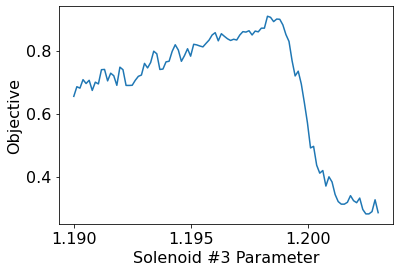

In [11]:
# H1_list = np.linspace(1000,2200,num=100)
# deltaH_list = np.linspace(-20,20,num=100)
# OBJ_list = np.linspace(-3.7515e6,-3.7495e6,num=100)
S3_list = np.linspace(1.19e5, 1.203e5, num=100)
# S4_list = np.linspace(6.4e5, 6.51e5, num=100)
# S6_list = np.linspace(3.87e5, 3.91e5, num=100)
# S7_list = np.linspace(-6.55e5,-6.35e5, num=100)
plt.plot(S3_list/1e5, prediction[:,0])

# plt.xlabel('S3', fontsize=16)
plt.ylabel('Objective', fontsize = 16)
plt.xlabel('Solenoid #3 Parameter', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=6)
# plt.legend(fontsize=16)
# plt.axvline(x = 1498, c = 'r')

## Run line scan for each of the parameter

Using TensorFlow backend.


Model loaded
Model loaded


/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chenyu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Using CNN prediction.
saving ronchigram...


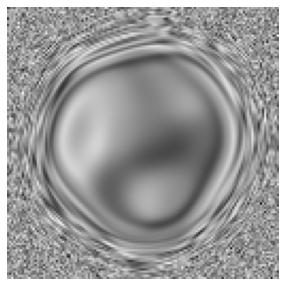

In [4]:
ndim = 6
dev_ids =  [str(x+1) for x in np.arange(ndim)]
x_low = np.asarray([1000, -40, 387000, -660000, 119000, 640000])
x_high = np.asarray([2800, 40, 393000, -635000, 120300, 651000])
start_point = [1498.216 , 0.47, 390000 , -654100, 119931.5, 648691.415]
start_point = [(start_point - x_low)/(x_high - x_low)]
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption=1,
                                CNNpath = model_path, DefocusOption = 1, S2 = 1)

mi.getState()
fig = plt.figure(figsize = [5,5])
temp = np.load('ronchigram.npy')
plt.imshow(temp, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
print(mi.S2)
print(start_point)

1
[array([0.27678667, 0.505875  , 0.5       , 0.236     , 0.71653846,
       0.79012864])]


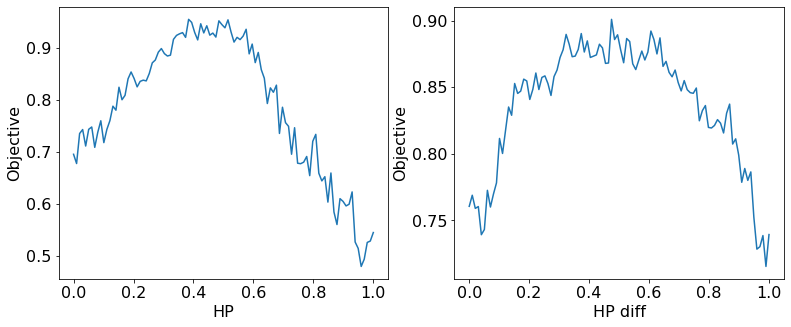

In [11]:
H1_list = np.linspace(0, 1,num=100)
emit_profile = np.zeros([100,1])
emit_profile = np.load('H1_1000_2800_100steps_40mrad_Coarse_CNNemittance.npy')

fig = plt.figure(figsize = [13,5])
plt.subplot(121)
plt.plot(H1_list, emit_profile)
plt.xlabel('HP', fontsize=16)
plt.ylabel('Objective', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=6)
plt.locator_params(axis="y", nbins=6)

emit_profile = np.load('deltaH_-40_40_100steps_40mrad_Coarse_CNNemittance.npy')
plt.subplot(122)
plt.plot(H1_list, emit_profile)
plt.xlabel('HP diff', fontsize=16)
plt.ylabel('Objective', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=6)
plt.locator_params(axis="y", nbins=6)

1.0 [0.54519749]


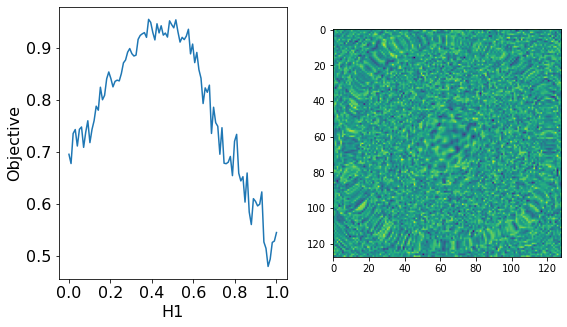

In [16]:
# Line scan for H1
# Parameters in the order of H1, dH, S6, S7, S3, S4
# Objective lens and S1, S2 condenser lenses are fixed here.

H1_list = np.linspace(0, 1,num=100)
emit_profile = np.zeros([100,1])
ronch_list = []
emit_profile = np.load('H1_1000_2800_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(H1_list)):
    
    start_point = [[H1_list[i], 0.505875, 0.5, 0.236, 0.71653846, 0.79012864]]    
    mi.setX(start_point)
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(H1_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(H1_list, emit_profile)
    plt.xlabel('H1', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=6)
    plt.locator_params(axis="y", nbins=6)
#     plt.axvline(x = 1498, c = 'r')
    
    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    np.save('H1_1000_2800_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
    np.save('H1_1000_2800_100steps_RonchigramList.npy', np.asarray(ronch_list))

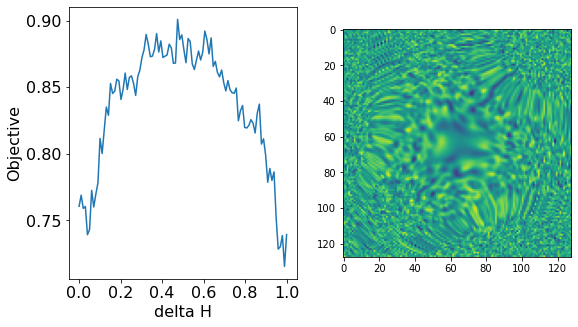

In [18]:
# Line scan for deltaH
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

deltaH_list = np.linspace(0, 1, num=100)
emit_profile = np.zeros([100,1])
ronch_list = []

for i in range(len(deltaH_list)):
    
    if emit_profile[i]!=0:
        continue
    start_point = [[0.27678667, deltaH_list[i], 0.5, 0.236, 0.71653846, 0.79012864]]   
    mi.setX(start_point)
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(H1_list, emit_profile)
    plt.xlabel('HP diff', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=6)
    plt.locator_params(axis="y", nbins=6)
#     plt.axvline(x = 0, c = 'r')
    
    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
#     np.save('deltaH_-40_40_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
#     np.save('deltaH_-40_40_100steps_RonchigramList.npy', np.asarray(ronch_list))

1.0 [0.37528342]


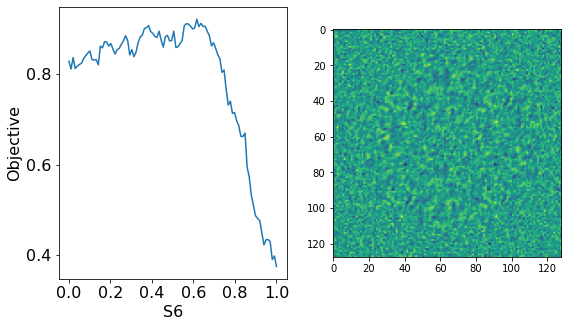

In [20]:
# Line scan for S6
# ndim = 7 #input dimension, set to 2 for two hexapoles
# acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

# dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

S6_list = np.linspace(0, 1, num=100)
emit_profile = np.zeros([100,1]) - 0.7
ronch_list = []

for i in range(len(S6_list)):

    start_point = [[0.27678667, 0.505875, S6_list[i], 0.236, 0.71653846, 0.79012864]] 
    mi.setX(start_point)
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(S6_list[i], emit_profile[i])
    
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(S6_list, emit_profile)
    plt.xlabel('S6', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=6)
    plt.locator_params(axis="y", nbins=6)
#     plt.axvline(x = 3.9, c = 'r')
    
    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    np.save('S6_3.87e5_3.93e5_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
    np.save('S6_3.87e5_3.93e5_100steps_Ronchigram_list.npy',np.asarray(ronch_list))

1.0 [0.79971951]


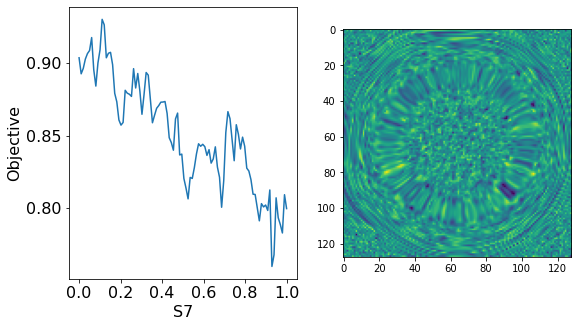

In [21]:
# Line scan for S7
# ndim = 7 #input dimension, set to 2 for two hexapoles
# acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

# dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S6, S7, OBJ, S3, S4

S7_list = np.linspace(0, 1, num=100)
emit_profile = np.zeros([100,1])
ronch_list = []

for i in range(len(S7_list)):
    start_point = [[0.27678667, 0.505875, 0.5, S7_list[i], 0.71653846, 0.79012864]] 
    mi.setX(start_point)
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(S7_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(S7_list, emit_profile)
    plt.xlabel('S7', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=6)
    plt.locator_params(axis="y", nbins=6)
#     plt.axvline(x = -6.54, c = 'r')

    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    np.save('S7_-6.60e5_-6.35e5_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
    np.save('S7_-6.60e5_-6.35e5_100steps_Ronchigram_list.npy',np.asarray(ronch_list))

1.0 [0.31891668]


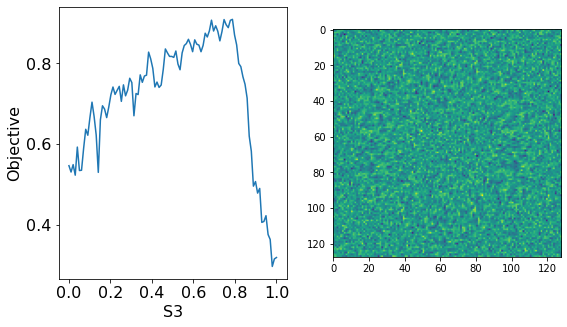

In [22]:
# Line scan for S3
# ndim = 7 #input dimension, set to 2 for two hexapoles
# acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

# dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

S3_list = np.linspace(0, 1, num=100)
emit_profile = np.zeros([100,1])
ronch_list = []

for i in range(len(S3_list)):
    start_point = [[0.27678667, 0.505875, 0.5, 0.236, S3_list[i], 0.79012864]] 
    mi.setX(start_point)
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(S3_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(S3_list, emit_profile )
    plt.xlabel('S3', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=6)
    plt.locator_params(axis="y", nbins=6)
    # 119931 is clearly not the optimal value for S3
#     plt.axvline(x = 1.19931, c = 'r')
    
    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    np.save('S3_1.19e5_1.203e5_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
    np.save('S3_1.19e5_1.203e5_100steps_Ronchigram_list.npy',np.asarray(ronch_list))

1.0 [0.42238015]


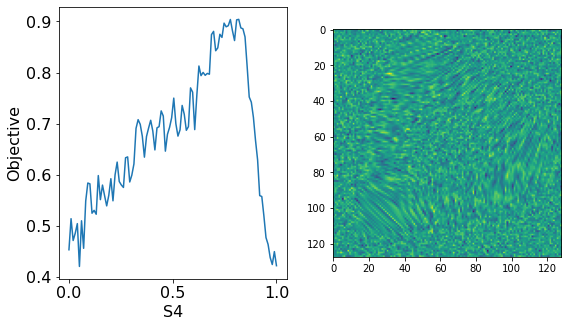

In [23]:
# Line scan for S4

S4_list = np.linspace(0, 1, num=100)
emit_profile = np.zeros([100,1])
ronch_list = []

for i in range(len(S4_list)):
    start_point = [[0.27678667, 0.505875, 0.5, 0.236, 0.71653846, S4_list[i]]] 
    mi.setX(start_point)
    emit_profile[i] = mi.getState()[1][0]

    clear_output(wait=True)
    print(S4_list[i], emit_profile[i])

    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(S4_list, emit_profile)
    plt.xlabel('S4', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=6)
#     plt.axvline(x = 6.48691, c = 'r')

    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    np.save('S4_6.4e5_6.51e5_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
    np.save('S4_6.4e5_6.51e5_100steps_Ronchigram_list.npy',np.asarray(ronch_list))

## Combine linescans for hyperparameter trainer

In [1]:
x = []
y = []

In [5]:
# Combine the data from different linescans
H1_list = np.linspace(0, 1, num=100)
emit_profile = np.load('H1_1000_2800_100steps_40mrad_Coarse_CNNemittance.npy')
for i in range(len(H1_list)):
    start_point = [[H1_list[i], 0.505875  , 0.5       , 0.236     , 0.71653846,
       0.79012864]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [6]:
deltaH_list = np.linspace(0, 1, num=100)
emit_profile = np.load('deltaH_-40_40_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(deltaH_list)):
    start_point = [[0.27678667, deltaH_list[i]  , 0.5       , 0.236     , 0.71653846,
       0.79012864]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [7]:
S3_list = np.linspace(0, 1, num=100)
emit_profile = np.load('S3_1.19e5_1.203e5_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(S3_list)):
    start_point = [[0.27678667, 0.505875  , 0.5       , 0.236     , S3_list[i],
       0.79012864]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [8]:
S4_list = np.linspace(0, 1, num=100)
emit_profile = np.load('S4_6.4e5_6.51e5_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(S4_list)):
    start_point = [[0.27678667, 0.505875  , 0.5       , 0.236     , 0.71653846, S4_list[i]]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [9]:
S6_list = np.linspace(0, 1,num=100)
emit_profile = np.load('S6_3.87e5_3.93e5_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(S6_list)):
    start_point = [[0.27678667, 0.505875  , S6_list[i]       , 0.236     , 0.71653846,
       0.79012864]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [10]:
S7_list = np.linspace(0, 1, num=100)
emit_profile = np.load('S7_-6.60e5_-6.35e5_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(S7_list)):
    start_point = [[0.27678667, 0.505875  , 0.5       , S7_list[i]     , 0.71653846,
       0.79012864]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [11]:
np.save('OBJ_x.npy',np.squeeze(np.asarray(x)))
np.save('OBJ_y.npy',np.squeeze(np.asarray(y)))

## Aux Functions

## Previously used scripts

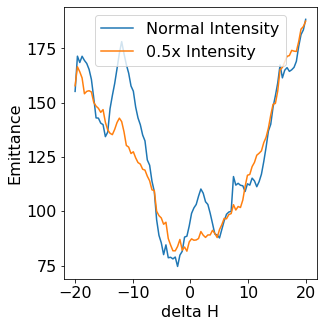

In [12]:
emit_profile = np.load('deltaH_-20_20_100steps_40mrad_Coarse_CNNemittance.npy')
emit_profile_halfInt = np.load('deltaH_-20_20_100steps_40mrad_Coarse_CNNemittance_halfIntensity.npy')
fig = plt.figure(figsize = [10,5])
plt.subplot(121)
plt.plot(deltaH_list, -emit_profile*1112.7, label = 'Normal Intensity')
plt.plot(deltaH_list, -emit_profile_halfInt*1112.7, label = '0.5x Intensity')
plt.xlabel('delta H', fontsize=16)
plt.ylabel('Emittance', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=6)
plt.locator_params(axis="y", nbins=6)
plt.legend(fontsize = 16)
# plt.axvline(x = 0,c = 'r')

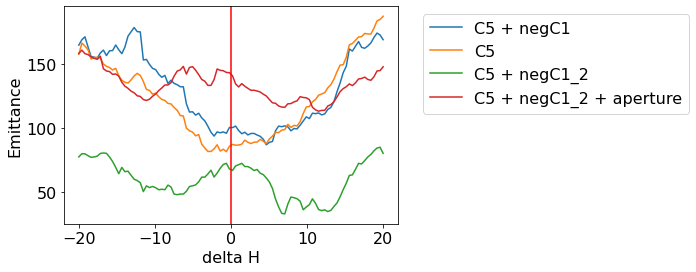

In [30]:
emit_profile = np.load('Linescans/HighCs_3fold_C5negC1_emit_WhiteNoise/deltaH_-20_20_100steps_40mrad_Coarse_CNNemittance.npy')
S6_list = np.linspace(387000,391000,num=100)
emit_profile_2 = np.load('Linescans/HighCs_3fold_C5_emit_WhiteNoise/deltaH_-20_20_100steps_40mrad_Coarse_CNNemittance.npy')
emit_profile_3 = np.load('Linescans/HighCs_3fold_C5negC1_emit_WhiteNoise_aperture/deltaH_-20_20_100steps_40mrad_Coarse_CNNemittance.npy')
plt.plot(deltaH_list, -emit_profile*1112.7, label = 'C5 + negC1')
plt.plot(deltaH_list, -emit_profile_2*1112.7, label='C5')
plt.plot(deltaH_list, -emit_profile_3 * 1112.7, label = 'C5 + negC1_2')
plt.plot(deltaH_list, prediction[:,0]*1112.7, label = 'C5 + negC1_2 + aperture')
plt.xlabel('delta H', fontsize=16)
plt.ylabel('Emittance', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=6)
plt.locator_params(axis="y", nbins=6)
plt.axvline(x = 0, c = 'r')
plt.legend(fontsize = 16,bbox_to_anchor=(1.05, 1), loc='upper left')

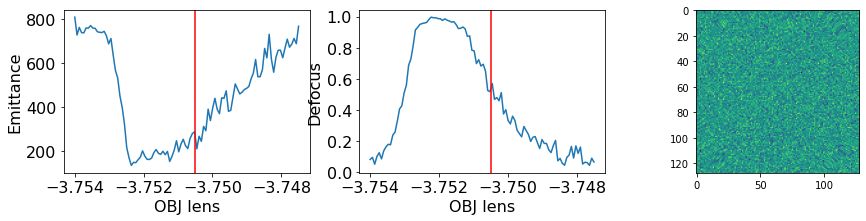

In [22]:
# Line scan for objective lens
# ndim = 7 #input dimension, set to 2 for two hexapoles
# acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

# dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

OBJ_list = np.linspace(-3.754e6,-3.7475e6,num=100)
emit_profile = np.zeros([100,1])

y_list = np.zeros([100,1])
x_list = np.zeros([100,1])

x_low = np.asarray([ 1000, -20,  387000, -655000, -3.7515e6, 119000, 640000])
x_high = np.asarray([ 2200, 20,  391000, -635000, -3.7495e6, 120300, 651000])
ronch_list = []


for i in range(len(OBJ_list)):

#     start_point = [1498 , 0, 390000 , -654100, OBJ_list[i], 119931.5, 648691.415] # default start point
    start_point = [1798 , 10, 391000 , -654200, OBJ_list[i], 119400, 648691.415]
    start_point = [(start_point - x_low)/(x_high - x_low)]
    mi.setX(start_point)
    emit_profile[i] = mi.getState()[1][0]
    y_list[i] = mi.getDefocus()
    x_list[i] = start_point[0][4]
    clear_output(wait=True)
 
    fig = plt.figure(figsize = [15,3])
    
    plt.subplot(131)
    plt.plot(np.asarray(OBJ_list/1e6), (1-emit_profile)*1057.5)
    plt.xlabel('OBJ lens', fontsize=16)
    plt.ylabel('Emittance', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=6)
    plt.axvline(x = -3.7505, c = 'r')
    
    plt.subplot(132)
    plt.plot(np.asarray(OBJ_list/1e6), y_list)
    plt.xlabel('OBJ lens', fontsize=16)
    plt.ylabel('Defocus', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=6)
    plt.axvline(x = -3.7505, c = 'r')
    
    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    
    plt.subplot(133)
    plt.imshow(temp)
    plt.show()
    
np.save('OBJ_scan_03.npy', y_list)
np.save('OBJ_scan_x.npy', x_list)

-648939.3939393939
Model loaded
[-0.24690656]


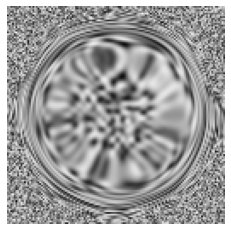

In [31]:
ndim = 7 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

S7_list = np.linspace(-655000,-640000, num=100)
i = 40
print(S7_list[i])
start_point = [[1498.2, 0, 3.90e5, -647725, -3.7505e6, 119931.5, 648691.415]] 
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption=1) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
print(mi.getState()[1][0])

temp = np.load('ronchigram.npy')
plt.imshow(temp, cmap='gray')
plt.axis('off')
plt.show()
